# Simulating Branching Processes with Various Lifetime Distributions
Michael Murrietta

4/4/2018

## Introduction
One description of a branching process is one that begins with a single entity that can spawn child entities during its lifetime and those will cease to begin their "work" until the parent entity completes. During their "work" these child entities can also create child entities with the same conditions. This is called a "Birth-and-Assassination" process and was first described by David Aldous and William Krebs. The main parameters of interest in this scheme are the distributions that govern lifetimes of each entity and the distributions that govern how many child entities are spawned. Deborah Nolan and Duncan Temple Lang explain the usage of the Poisson distribution in describing how many entities are spawned during a fixed time interval and also how the exponential distribution describes their spawn times and life lengths. This exercise explores the use of any other continuous distribution in describing life lengths and spawn times.

## Abstract
Functions created by Nolan and Lang to model the Birth-and-Assassination type branching process were modified to allow for any random number generating function to be used to model lifetimes. An analysis similar to the authors' is explored using the uniform distribution with a range of $[80, 100]$. The original exploration included a grid search over the parameters kappa and lambda however kappa is not necessarily useful in the context of using other random number generator functions so an exploration of the lifetime range was explored instead. The results show ...

# TODO:
+ Work out how we will explore a replacement for kappa (i'm thinking of just providing either the min or max and having a parameter that provides the other end of the range, this is analogous to kappa for the exponential distribution)
+ Add comparative notes and possibly equivalent demonstrations of the original work outlined in chapter 8.
+ Write up the results
+ Write up the conclusion

#### Problem Statement:
Problem 11 from chapter 7 of the text by Nolan and Lang [Nolan & Lang, 2015]:

+ Consider other probability functions to describe the lifetime of a process. Revise `familyTree()` and `genKidsV()` to take as an argument the random number generator for any probability distribution. The functions `familyTree()` and `genKidsV()` are to use this probability distribution (with arguments that may be specific to the distributions) to generate the completion times of jobs.

## Methods
The problem was most easily addressed using the `...` operator in `R`. Each function was modified to incorporate a `FUN` and `...` parameter. The `FUN` parameter is a function and the `...` are the named parameters used in `FUN`. The convention in `R` is to use explicit names in `...` rather than abbreviations so it is up to the user to specify the correctly named arguments for `FUN`. Some parameter names had to be changed in `genKidsV`, namely `min` and `max` since the random number generating function `runif` uses these parameters as well. Most of the exploration and plots are due to an analogous exploration followed in chapter 8 by the authors [Nolan & Lang, 2015].

In [29]:
#different prob dists to try
#runif(10)  #(may want to round to nearest integer)
#rnorm(n=10, mean=0, sd=1) #also may want to discretize
#rbinom(n=10, size=100, prob=0.5) #perhaps convert to a proportion of successes?
#rexp(n=100, rate=10) #mean is 1/rate
#rgamma(n=100, shape=20)

In [160]:
genKidsV2 = function(bTimes, cTimes, parentID, lambda = 0.5, kappa = 0.3, FUN=rexp, ...) {
       # Determine how many children each job has
  parentAge = cTimes - bTimes
  numKids = rpois(n = length(parentAge), lambda = lambda * parentAge)
  
  if (sum(numKids) == 0) return(NULL)
  
       # Determine the birth times of the children  
      #added "n" to the end of the min and max used in the lambda function
      #to avoid ambiguity if using FUN=runif(n, min, max)
  kidStats = 
    mapply(function(n, minn, maxn) {
      births = sort(runif(n, minn, maxn))
      runtimes = FUN(n, ...)
      completes = rep(maxn, n) + runtimes
      data.frame(births, completes)
    },
           n = numKids , minn = bTimes, maxn = cTimes, 
           SIMPLIFY = FALSE)
  
 
  return(data.frame(parentID = rep(parentID, numKids),
                    kidID = 1:sum(numKids), 
                    births = unlist(lapply(kidStats, "[[", "births")), 
                    completes = unlist(lapply(kidStats,"[[", "completes"))
                    ))
}

In [161]:
familyTree2 = function(lambda = 0.5, kappa = 0.3, 
                      maxGen = 10, maxOffspring = 1000,
                     FUN = rexp, ...) {
  #assume all dots belong to FUN, this means we need to explicitly specify
  #rate is kappa if using rexp

       # Return value - a list with 1 data frame per generation.
  allGens = vector(mode = "list", length = maxGen)
  
       # Generate root of the tree
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, 
                            births = 0, 
                            completes = FUN(n=1, ...))
  
  currentNumOffspring = 0

       # Generate future generations, one at a time.
  for (i in 2:maxGen) {
    nextGen = genKidsV2(bTimes = allGens[[ (i - 1) ]]$births,
                       cTimes = allGens[[ (i - 1) ]]$completes,
                       parentID = allGens[[ (i - 1) ]]$kidID,
                       lambda = lambda, kappa = kappa, FUN=FUN, ...)
    if (is.null(nextGen)) return(allGens[ 1:(i - 1) ]) 
    allGens[[ i ]] = nextGen
    currentNumOffspring = currentNumOffspring + nrow(nextGen)
    if (currentNumOffspring > maxOffspring) 
      return(allGens[1:i])
  }  
  allGens
}

In [189]:
familyTreeT2 = function(lambda = 0.5, kappa = 0.3, maxTime = 8, FUN=rexp, ...) {
       # maxTime - maximum length of time to observe the process
  allGens = list()
  
       # Generate the root of the 
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, 
                            births = 0, 
                            completes = FUN(1, ...))
  
       # Generate the future generations, one at a time.
  numGens = 1
  while (TRUE) {
    nextGen = genKidsV2(bTimes = allGens[[ numGens ]]$births,
                       cTimes = allGens[[ numGens ]]$completes,
                       parentID = allGens[[ numGens ]]$kidID,
                       lambda = lambda, kappa = kappa, FUN=FUN, ...)
    
    if ( is.null(nextGen) | (min(nextGen$births) > maxTime) ) {
           # If complete after maxTime set complete to NA
      allGens = lapply(allGens, function(gen) {
        gen$completes[ gen$completes > maxTime ] = NA
        gen
      })
      return(allGens)
    }
    
    # Drop those born after maxTime 
    nextGen = nextGen[ nextGen$births <= maxTime , ]
    nextGen$kidID = 1:nrow(nextGen)
    numGens = numGens + 1
    allGens[[ numGens ]] = nextGen    
  }  
}	

In [183]:
# familyTree2(lambda = 0.5, kappa = 0.3, 
#             maxGen = 10, maxOffspring = 1000,
#             FUN=runif, min=100, max=102)
seed2 = 12212013
set.seed(seed2)
tree = familyTree2(lambda = 1, kappa = 0.5, 
                  maxGen = 100, maxOffspring = 1000,
                  FUN=rgamma, shape=20)

length(tree)

sapply(tree, nrow)

sum(sapply(tree, nrow))

[1] 4

[1]     1    24   690 23770

[1] 24485

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

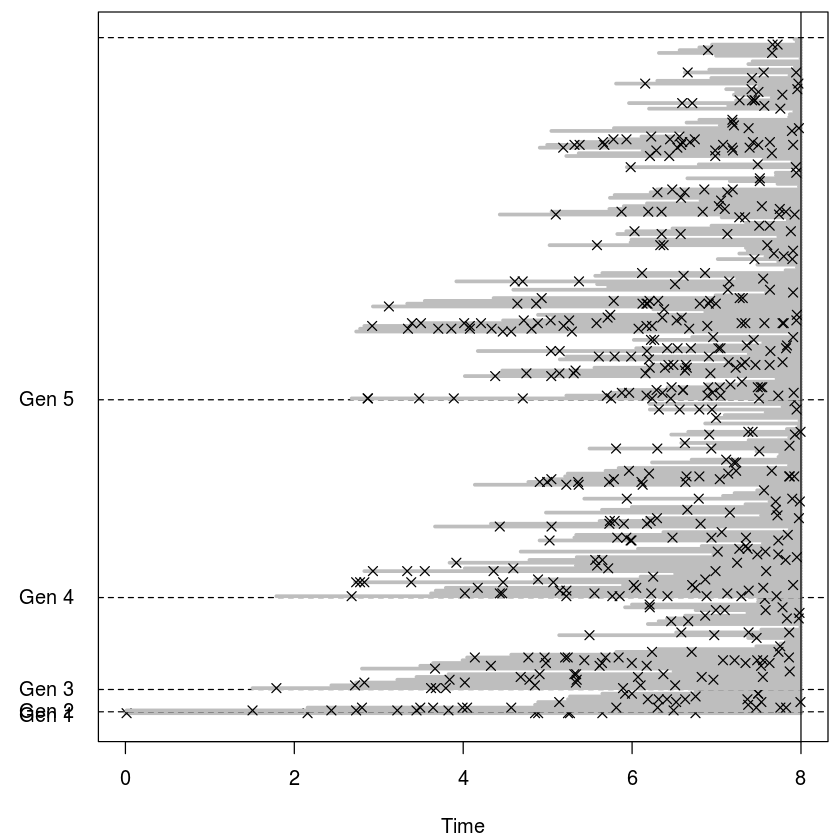

In [191]:
set.seed(seed2)
treeVT = familyTreeT2(lambda = 1, kappa = 0.5, maxTime=8, FUN=runif, min=80, max=100)

numGen = 5
treeSub = treeVT[1:numGen]
numKids = sapply(treeSub, nrow)
numFamily = sum(numKids)

treeSub = lapply(treeSub, 
                 function(gen) {
                   gen$completes[ is.na(gen$completes) ] = 8
                   gen
                   })

treeSubN = treeVT[ 2:(numGen + 1) ]
treeSubN = lapply(treeSubN, 
                  function(gen) {
                    gen$completes[ is.na(gen$completes) ] = 8
                    gen
                 })
  
maxLife = max(sapply(treeSub, function(gen) max(gen$completes)))

birthNum = c(0, cumsum(numKids)[ -numGen ])

# pdf("BA_FamilyTreeVT.pdf", width = 8, height = 15)
oldPar = par(mar = c(4.1, 4.1, 0.5, 0.5))

plot(0,0, ylim = c(0.5, numFamily), xlim = c(0, maxLife),
     xlab = "Time", ylab = "", type ="n",
     axes = FALSE)

box()
axis(1)
axis(2, at = birthNum + c(0.5, rep(1, (numGen-1))), 
     labels = paste("Gen", 1:numGen), tick = FALSE, las = 1)

mapply(function(gen, nextGen, birthNum) {
  birthOrder = birthNum + (1:nrow(gen))
  segments(x0 = gen$births, x1 = gen$completes, y0 = birthOrder,
           lwd = 3, col = "grey")
  abline(h = 0.5 + max(birthOrder), lty = 2, col="black" )
  points(x = nextGen$births, y = birthOrder[nextGen$parentID],
           pch = 4)
}, gen = treeSub, nextGen = treeSubN, birthNum = birthNum )

abline(v = maxLife)

par(oldPar)
# dev.off()

In [192]:
exptOne2 = function(l, k, mG, mO, FUN=rexp, ...){
       # Helper function to call familyTree
       # Returns - summary statistics for analysis,
  
  aTree = familyTree2(lambda = l, kappa = k, maxGen = mG,
                      maxOffspring = mO, FUN=FUN, ...)
  numGen = length(aTree)
  numJobs = sum(sapply(aTree, nrow))
  c(numGen, numJobs)
}

In [193]:
set.seed(seed2)
exptOne2(1, 0.5, 100, 1000, FUN=runif, min=80, max=100)

[1]     3 10194

In [194]:
familyTreeT2 = function(lambda = 0.5, kappa = 0.3, maxTime = 8, FUN=rexp, ...) {
  # maxTime - maximum length of time to observe the family
  allGens = list()
  
  # Generate the root of the 
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, 
                            births = 0, 
                            completes = FUN(1, ...))
  
  # Generate the future generations, one at a time.
  numGens = 1
  while (TRUE) {
    nextGen = genKidsV2(bTimes = allGens[[ numGens ]]$births,
                       cTimes = allGens[[ numGens ]]$completes,
                       parentID = allGens[[ numGens ]]$kidID,
                       lambda = lambda, kappa = kappa, FUN=FUN, ...)
    
    treeTerminated = is.null(nextGen)
    if ( !treeTerminated ) {
      birthsPastObsTime = min(nextGen$births) > maxTime
    }
    else birthsPastObsTime = TRUE
    
    if ( treeTerminated | birthsPastObsTime ) {
      # If complete after maxTime set complete to NA
      allGens = lapply(allGens, function(gen) {
        gen$completes[ gen$completes > maxTime ] = NA
        gen
      })
      return(allGens)
    }
    
    # Drop those born after maxTime 
    nextGen = nextGen[ nextGen$births <= maxTime , ]
    nextGen$kidID = 1:nrow(nextGen)
    numGens = numGens + 1
    allGens[[ numGens ]] = nextGen    
  }  
}

In [196]:
MCBA2 = function(params, repeats = 5, mG = 10, mO = 1000, FUN=rexp, ...){
       # params: matrix columns of lambda and kappa values
       # For each lambda and kappa pair, run "repeats" times
  
  n = nrow(params)
  mcResults = vector("list", length = n)
  
  for (i in 1:n) {
    cat("param set is ", i, "\n")
    mcResults[[i]] = replicate(repeats,
                               exptOne2(l = params[i, 1],
                                       k = params[i, 2],
                                       mG = mG, mO = mO, FUN=FUN, ...))
  }
  mcResults
}

In [198]:
trialKappas = c(0.1, 10, 0.1, 10)
trialLambdas = c(0.1, 0.1, 10, 10)
trialParams = matrix(c(trialLambdas, trialKappas), ncol = 2)
mcTrialOutput = MCBA2(params = trialParams, repeats = 10, 
                     mG = 200, mO = 100, FUN=runif, min=80, max=100)
# save(mcTrialOutput, file = "mcTrialOutput.rda")

param set is  1 
param set is  2 
param set is  3 
param set is  4 


In [199]:
#note that kappa doesn't influence lifetime length anymore unless we 
#explicitly link it somehow. for rexp it would be providing rate=kappa
#for other functions we'd need to be a little creative
#it makes sense that maybe we modify MCBA2 to allow traversal of other params
mcTrialOutput

1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,2,1
1,1,1,1,1,1,1,1,2,1
4,6,5,4,4,4,4,3,4,4
576,233,973,399,502,200,355,103,212,105
3,3,4,4,4,4,4,4,3,4
145,108,827,1071,163,679,434,292,135,342


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

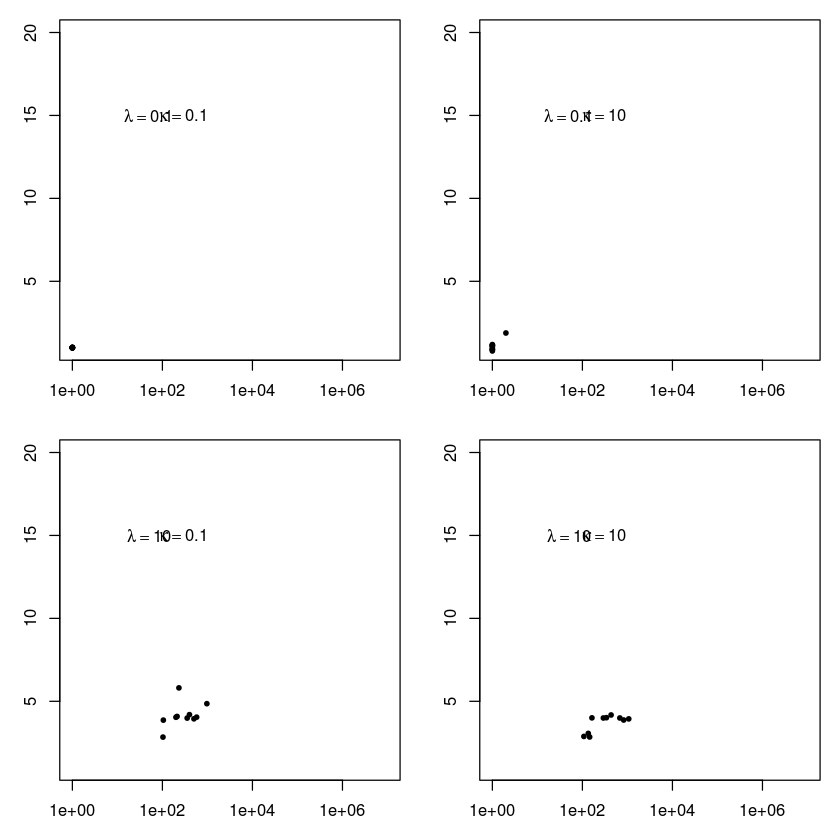

In [200]:
# pdf("BA_ScatterPlotNumGenByNumKids.pdf", width = 10, height = 8)

oldPar = par(mfrow = c(2, 2), mar = c(3,3,1,1))

mapply(function(oneSet, lambda, kappa) {
  plot(x = oneSet[2,], y = jitter(oneSet[1, ], 1), log = "x",
       ylim = c(1,20), xlim = c(1, 10^7), pch = 19, cex = 0.6)
  text(x = 50, y = 15, bquote(paste(lambda == .(lambda))) )
  text(x = 300, y = 15, bquote(paste(kappa == .(kappa))) )
  }, 
  mcTrialOutput, lambda = trialLambdas, kappa = trialKappas)

par(oldPar)

# dev.off()

In [202]:
lambdas = c(seq(0.1, 0.6, by = 0.1), seq(0.8, 2, by = 0.2), 
            seq(2.25, 3, by = 0.25))
kappas = c(lambdas, 3.25, 3.50, 3.75, 4.00, 4.50, 5.00)

paramGrid = as.matrix(expand.grid(lambdas, kappas))

# pdf("BA_Scatterplot3Dkids.pdf", width = 7, height = 6)

mcGrid = MCBA2(params = paramGrid, repeats = 10, mG = 20,
                mO = 100, FUN=runif, min=80, max=100)

# save(mcGrid, file = "mcGridOutput.rda")

param set is  1 
param set is  2 
param set is  3 
param set is  4 
param set is  5 
param set is  6 
param set is  7 
param set is  8 
param set is  9 
param set is  10 
param set is  11 
param set is  12 
param set is  13 
param set is  14 
param set is  15 
param set is  16 
param set is  17 
param set is  18 
param set is  19 
param set is  20 
param set is  21 
param set is  22 
param set is  23 
param set is  24 
param set is  25 
param set is  26 
param set is  27 
param set is  28 
param set is  29 
param set is  30 
param set is  31 
param set is  32 
param set is  33 
param set is  34 
param set is  35 
param set is  36 
param set is  37 
param set is  38 
param set is  39 
param set is  40 
param set is  41 
param set is  42 
param set is  43 
param set is  44 
param set is  45 
param set is  46 
param set is  47 
param set is  48 
param set is  49 
param set is  50 
param set is  51 
param set is  52 
param set is  53 
param set is  54 
param set is  55 
param set is  56 
p

In [203]:
logUQkids = sapply(mcGrid, function(x) 
               log(quantile(x[2, ], probs = 0.75), base = 10))

UQCut = cut(logUQkids, breaks = c(-0.1, 0.5, 2, max(logUQkids)) )
color3 = c("#b3cde3aa", "#8856a7aa", "#810f7caa")
colors = color3[UQCut]

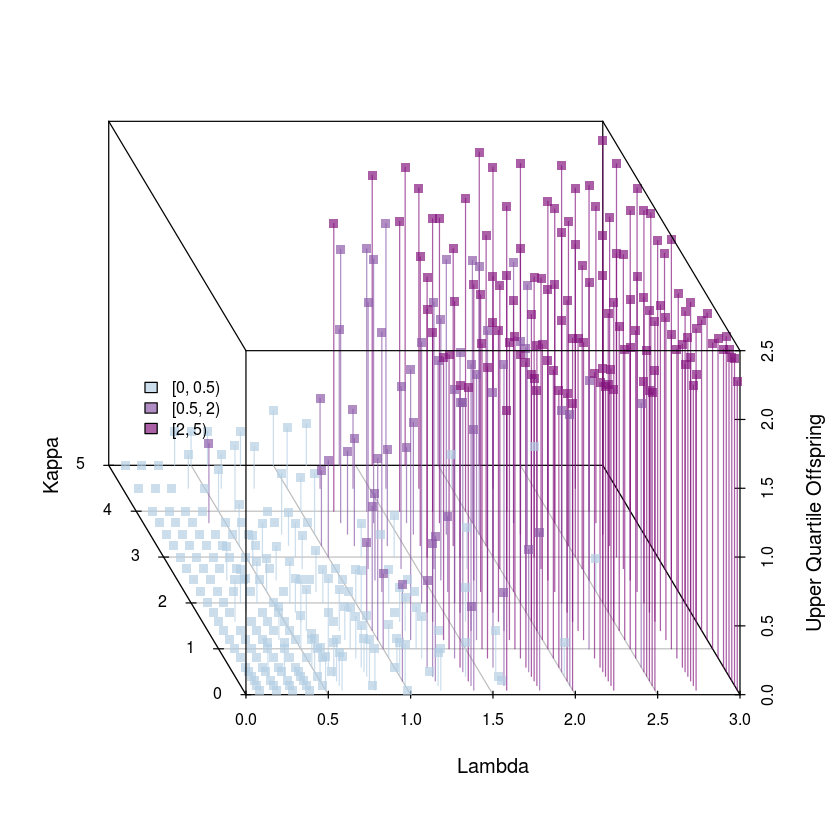

In [204]:
library(scatterplot3d)
sdp = scatterplot3d(x = paramGrid[ , 1], y = paramGrid[ , 2], 
                    z = logUQkids, pch = 15, color = colors,
                    xlab = "Lambda", ylab = "Kappa",
                    zlab = "Upper Quartile Offspring",
                    angle = 120, type="h")

legend("left", inset = .08, bty = "n", cex = 0.8,
       legend = c("[0, 0.5)", "[0.5, 2)", "[2, 5)"), 
       fill = color3)

# dev.off()

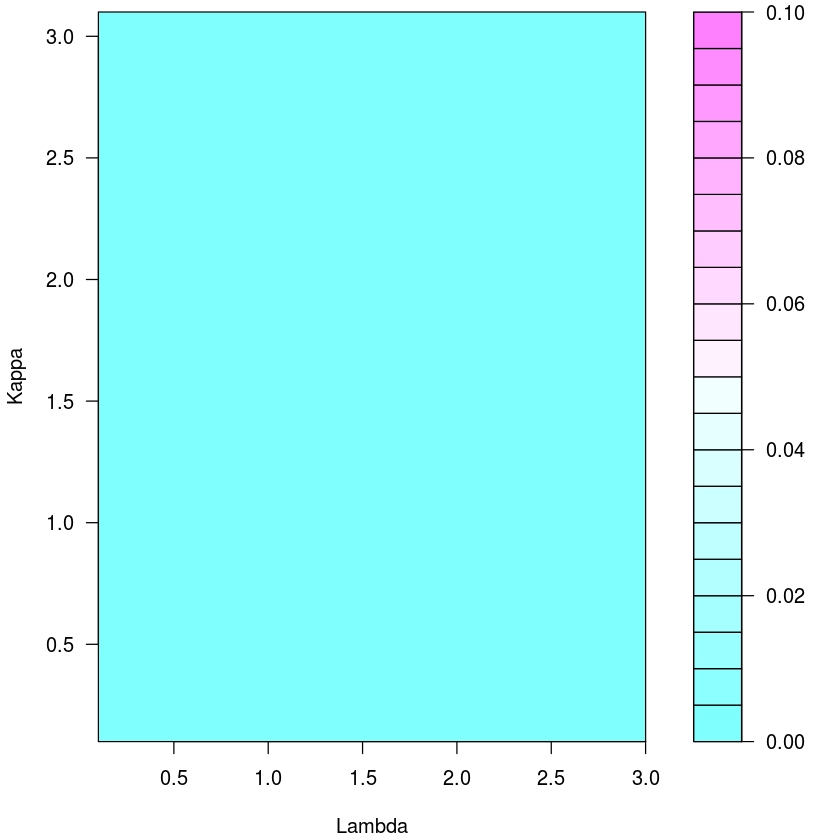

In [205]:
# pdf("BA_ImageMapAlive.pdf", width = 7, height = 7)
oldPar  = par(mar = c(4.1, 4.1, 0.5, 0.5))

mcGridAlive = sapply(mcGrid, function(oneParamSet) {
  sum((oneParamSet[1,] == 20) | (oneParamSet[2,] > 1000)) / 
    length(oneParamSet[2,]) })

filled.contour(lambdas, kappas, 
               matrix(mcGridAlive, nrow = length(lambdas), 
                      ncol = length(kappas)), 
               xlab = "Lambda", ylab = "Kappa", 
               xlim = c(0.1, 3), ylim = c(0.1, 3.1)) 

par(oldPar)
# dev.off()

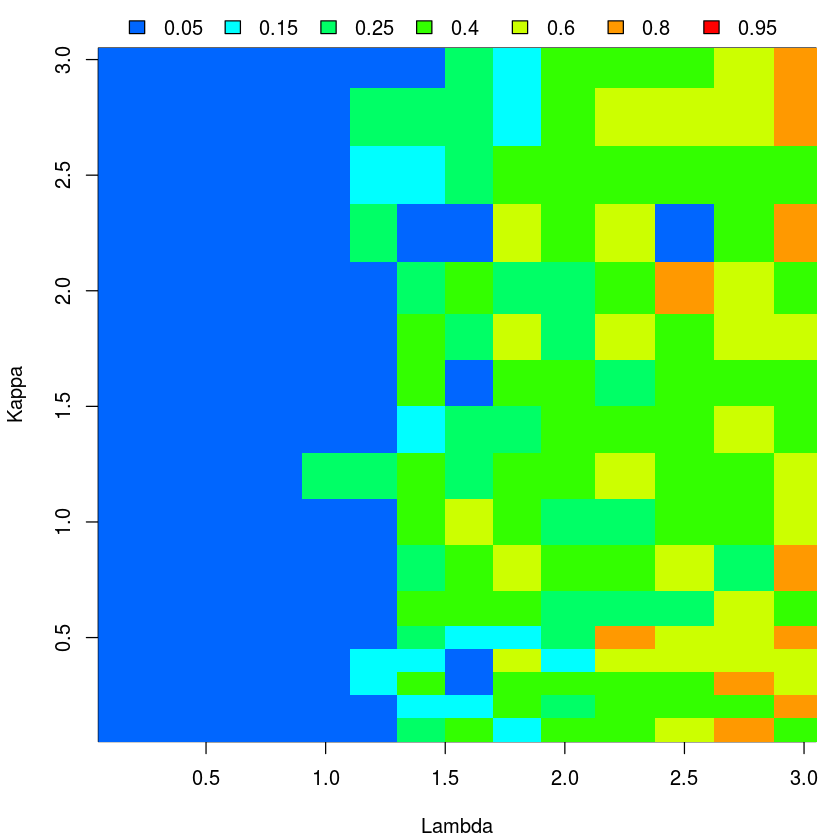

In [207]:
# pdf("BA_ImageMapAtleast20Kids.pdf", width = 7, height = 7)
oldPar  = par(mar = c(4.1, 4.1, 2, 1))

mcGridProp20kids = sapply(mcGrid, function(oneParamSet) {
  sum(oneParamSet[2,] > 19) / length(oneParamSet[2,]) })

mcGridProp20kidsMat = matrix(mcGridProp20kids, 
                             nrow = length(lambdas), 
                             ncol = length(kappas))

breaks = c(0, 0.10, 0.2, 0.3, 0.5, 0.7, 0.9, 1)
colors = rev(rainbow(10))[-(1:3)]

image(lambdas, kappas, mcGridProp20kidsMat, col = colors,
      breaks = breaks, xlab = "Lambda", ylab = "Kappa", 
      xlim = c(0.05, 3.05), ylim = c(0.05, 3.05))

midBreaks = (breaks[ -8 ] + breaks[ -1 ]) / 2
legend(x = 0.1, y = 3.25, legend = midBreaks, fill = colors, 
       bty = "n", ncol = 7,  xpd = TRUE)

par(oldPar)
# dev.off()

## Results

The best metric for comparing classification models in this scenario is the f1 score since it incorporates both precision and the true positive rate (recall). For the email client user the precision part informs us of how much of my wanted mail is being incorrectly classified by the model (1 - precision), the recall part tells us how much of the all possible spam did the model catch. Each of these is certainly important so to be able to effectively summarize them in a single score makes the f1 score a good choice. Using the f1 score as the ultimate metric shows the `naive_bayes_bow` method to be the best with an average out-of-fold f1 score of `0.965`. It is also clear in the ROC plot that the `naive_bayes_bow` method is the best but with the 100 tree `randomForest` model very close.

## Conclusion

The f1 score seemed to be the best metric for this scenario as it summarizes two important aspects of classification model performance. While there are some improvements to be made on the bag of words framework used with Naive Bayes the random forest model could still end up performing better. Indeed, it would be a simpler task to try various parameters on the random forest model than it would to make adjustments to the bag of words.

## References
[1] Nolan, Deborah and Lang, Temple. Data Science in R: A Case Studies Approach, Chapter 7: Simulation Study of a Branching Process. 2015 Taylor & Francis Group, LLC.